# CIFAR-10 Image Classifer
### By Aman Brar

## Overview and Purpose
In my recent project, I developed several convolutional neural networks (CNNs) to tackle the famous CIFAR-10 dataset, which comprises 60,000 32x32 color images in 10 classes, each with 6,000 images. My objective was to iteratively enhance model architectures to maximize classification accuracy. By leveraging this dataset, I am able to get more practice with image recognition and further improve my capabilities in this realm, an endeavor critical for advancements in fields like autonomous vehicles, healthcare, and security, where accurate image classification is paramount. This research not only contributes to the broader machine learning community but also hones my skills in neural network optimization and image processing.

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
import math 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

## Exploratory Data Analysis
In this part of the project my main goal was to understand the type of data I am working with even better. To do this I printed out 16 random images in the dataset and their associated labels. I also made sure that there were 50000 train images and 10000 test images with 6000 images in each of the classes.

In [3]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10(root='./data', train=True, download=True,  transform=transform)
load_train = torch.utils.data.DataLoader(train_data, batch_size=100,shuffle=True, num_workers=2)

test_data = datasets.CIFAR10(root='./data', train=False, download=True,transform=transform)
load_test = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:11<00:00, 14474139.78it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


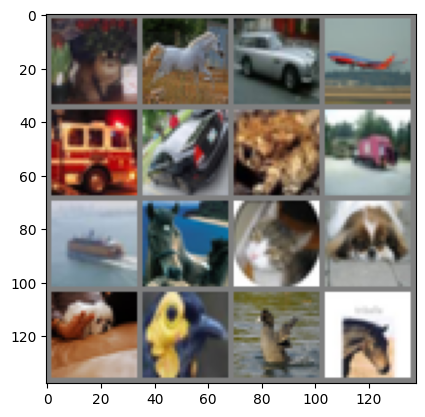

Labels of images in order:
cat | horse | automobile | airplane | truck | automobile | frog | truck | ship | horse | cat | dog | dog | bird | bird | horse


In [4]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(load_train)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:16], nrow=4))
print("Labels of images in order:")
print(' | '.join(f'{train_data.classes[labels[j]]}' for j in range(16)))

In [5]:
print(f'Number of images in the training dataset: {len(train_data)}')
print(f'Number of images in the testing dataset: {len(test_data)}')

Number of images in the training dataset: 50000
Number of images in the testing dataset: 10000


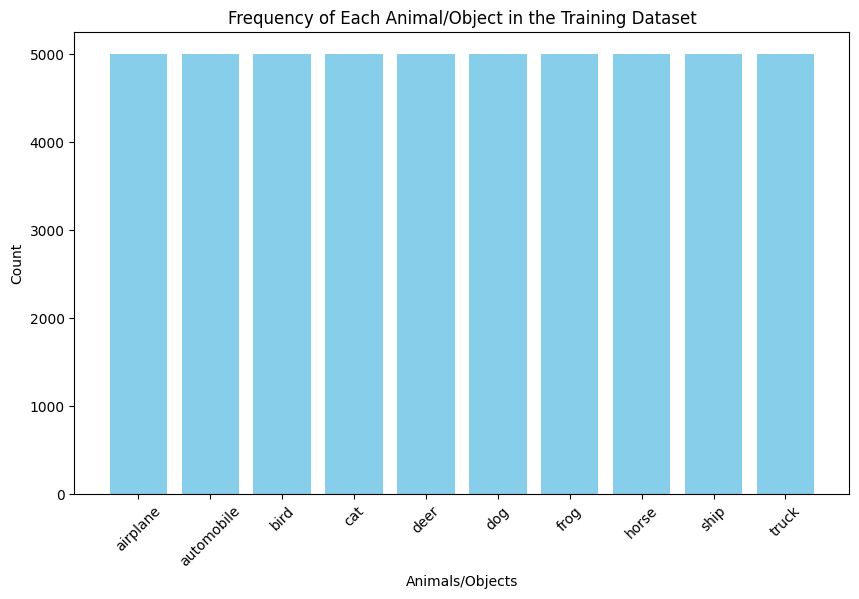

In [6]:
label_counts = np.zeros(10)
for _, label in train_data:
    label_counts[label] += 1
plt.figure(figsize=(10, 6))
plt.bar(train_data.classes, label_counts, color='skyblue')
plt.xlabel('Animals/Objects')
plt.ylabel('Count')
plt.title('Frequency of Each Animal/Object in the Training Dataset')
plt.xticks(rotation=45)
plt.show()

## Building and Training Models
In this process, I built out 4 different models each time trying to make adjustments that improve the accuracy of my model. I started with a simple base model which is a linear classifier with a single fully connected layer. First_iteration adds a hidden layer to the architecture for more complex representations. Second_iteration introduces a convolutional layer and pooling for spatial feature extraction. Third_iteration builds further, with two convolutional layers and three fully connected layers, increasing the model's depth for capturing hierarchies in data.

In [7]:
def train_model(net, train_loader, test_loader, num_epochs=10, learning_rate=0.001, compute_accs=False, verbose=False):
    train_accs = []
    test_accs = []
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    if torch.cuda.is_available():
        net = net.cuda()
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        if compute_accs:
            train_acc = get_accuracy(model, train_loader)  # Compute training accuracy for the current epoch
            test_acc = get_accuracy(model, test_loader)  # Compute test accuracy for the current epoch

            train_accs.append(train_acc)
            test_accs.append(test_acc)

    return train_accs, test_accs

In [8]:
def get_accuracy(net, data_loader):
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [9]:
class base(nn.Module):
    def __init__(self):
        super(base, self).__init__()
        self.fc = nn.Linear(3072, 10)

    def forward(self, x):
        x = x.view(-1, 3072) 
        x = self.fc(x)
        return x

In [10]:
class first_iteration(nn.Module):
    def __init__(self):
        super(first_iteration, self).__init__()
        self.fc1 = nn.Linear(3072, 300)
        self.fc2 = nn.Linear(300, 10)

    def forward(self, x):
        x = x.view(-1, 3072) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
class second_iteration(nn.Module):
    def __init__(self):
        super(second_iteration, self).__init__()
        self.conv1 = nn.Conv2d(3, 25, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(25 * 14 * 14, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 25 * 14 * 14)
        x = self.fc1(x)
        return x

In [12]:
class third_iteration(nn.Module):
    def __init__(self):
        super(third_iteration, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
def history_plt(histories):
    plt.figure(figsize=(16, 10))
    for model_history in histories:
        epochs = range(1, len(model_history['Train Accuracy']) + 1)
        plt.plot(epochs, model_history['Train Accuracy'], label=f"{model_history['name']} Train")
        plt.plot(epochs, model_history['Test Accuracy'], '--', label=f"{model_history['name']} Test")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim([1, max(epochs)])

base
first_iteration
second_iteration
third_iteration


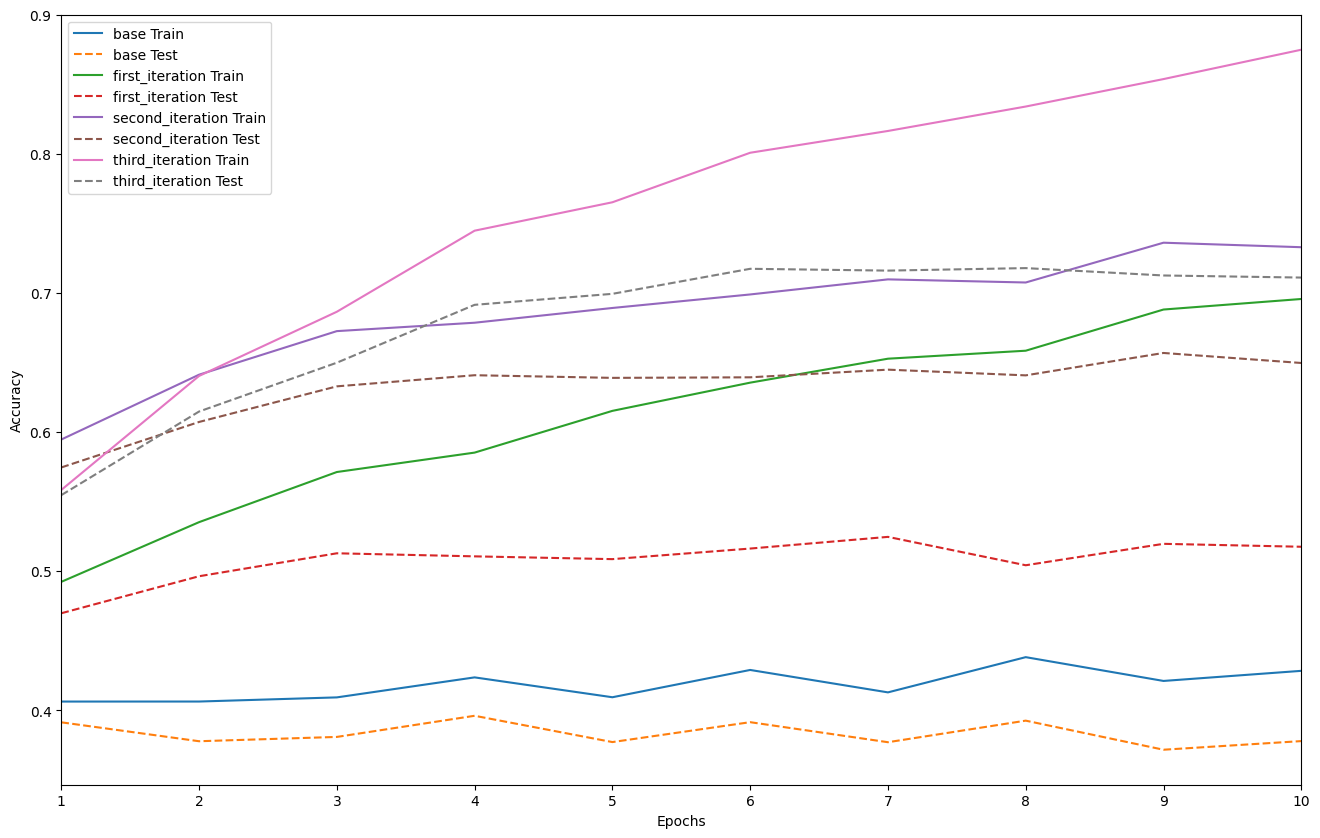

In [14]:
models = [base(), first_iteration(), second_iteration(), third_iteration()]
histories = []

for model in models:
    print(type(model).__name__)
    history_train, history_test = train_model(model, load_train, load_test,num_epochs=10,learning_rate=0.001,compute_accs=True)
    histories.append({
        'name': type(model).__name__, 
        'net': model, 
        'Train Accuracy': history_train, 
        'Test Accuracy': history_test
    })
history_plt(histories)

In [18]:
# Iterate through the histories list and find the maximum test accuracy for each model
for history in histories:
    model_name = history['name']
    max_test_accuracy = max(history['Test Accuracy'])
    print(f"Max test accuracy for {model_name}: {max_test_accuracy:.4f}")

Max test accuracy for base: 0.3962
Max test accuracy for first_iteration: 0.5248
Max test accuracy for second_iteration: 0.6570
Max test accuracy for third_iteration: 0.7180


## Conclusion and Results
In conclusion, throughout this project on the CIFAR-10 dataset, my models demonstrated a clear trend: as complexity increased, so did classification accuracy. The `third_iteration` model, with its two convolutional layers and additional fully connected layers, performed the best, achieving a maximum test accuracy of 0.7180. These results underscore the effectiveness of deeper architectures in image recognition tasks. Moving forward, I plan to explore further improvements such as data augmentation, hyperparameter tuning, and advanced regularization techniques to push the accuracy even higher.